<center>  <h1> Data 598 (Winter 2023): Midterm </h1> </center> 
    <center> University of Washington </center>
    

There are four parts in this midterm. 
1. Understanding automatic differentiation
1. Programming a differentiable module
1. Optimization a neural network
1. Explaining concepts from convolutional neural nets

**Rules**:
- No collaborations allowed! You must work on your own.
- You may refer to the reference books.
- You may refer to the labs, demos, lab solutions and homework solutions. 
- However, you may not directly copy-paste code from any of the labs or demos. You should write your own code.
- The only exception to the copy-paste rule is where explicitly specified. 

# Part 1: Understanding automatic differentiation

Consider the function $f: \mathbb{R} \to \mathbb{R}$ defined as 

$$
    f(x) =  \sqrt{2 + x^3 + \log (1+ x^3)} + \sin(2 + x^3 + \log (1+ x^3)) .
$$

<!-- $$
    f(x) = \sqrt{x^2 + \exp (x^2)} + \cos(x^2 + \exp(x^2)) \,.
$$ -->

Questions:

**A)** Write out the chain rule to compute the derivative $f'(x)$ of $f$ at a given $x$. Then, compute the gradient of y with respect to x. 
You may insert the equations in Markdown directly using LaTeX syntax. 

**Your answer here**: 

$$
\text{Let } y = 2 + x^3 + log(1+x^3)\\
$$
Then, we find $f'(x)$ as follows:
$$
\frac{df}{dx} = \frac{df}{dy}.\frac{dy}{dx} = (\frac{1}{2\sqrt{y}}+cos(y)).(3x^2+\frac{1}{1+x^3}.3x^2)
$$
Simplifying the above expression,
$$
\frac{df}{dx} = 3x^2[(\frac{1+2\sqrt{y}cos(y)}{2\sqrt{y}}).(\frac{1+x^3+1}{1+x^3})] = \frac{3x^2(x^3+2)[2\sqrt{y}cos(y)+1]}{(1+x^3)2\sqrt{y}}
$$
Substituting the value of $y$ we get,
$$
\frac{df}{dx} = \frac{3x^2(x^3+2)[2\sqrt{2 + x^3 + log(1+x^3)}cos(2 + x^3 + log(1+x^3))+1]}{2(1+x^3)\sqrt{2 + x^3 + log(1+x^3)}}
$$


**B)** Implement this function $f$ in code so that it accepts a scalar $x$ and returns $f(x)$. 

In [1]:
import torch
def my_function(x):
    # x is a torch.tensor (this is the PyTorch scalar type)
    # Example input `x = torch.tensor(3.14159, requires_grad=True)`
    # TODO: your code here

    y = 2 + x**3 + torch.log(1+x**3)

    return torch.sqrt(y) + torch.sin(y)

**C)** Compute the derivative $f'(x)$ for $x= 1.432$ using PyTorch's automatic differentiation. You do not have to code up your own backward method. 

In [2]:
# TODO: your code here
x = torch.tensor(1.432, requires_grad=True)
f_x = my_function(x)
gradient = torch.autograd.grad(outputs=f_x, inputs=x, allow_unused=True)[0]
print("x =",x,"\nf(x) =",f_x,"\ngradient =",gradient)

x = tensor(1.4320, requires_grad=True) 
f(x) = tensor(2.5349, grad_fn=<AddBackward0>) 
gradient = tensor(9.2485)


# Part 2: Coding up a differentiable module

Consider the soft-thresholding function $f_T: \mathbb{R} \to \mathbb{R}$ defined for any $T > 0$ as 
$$
    f_T(y) = 
    \begin{cases} 
        0, & \text{ if } -T \le y \le T \,, \\
        (y - T)^2, & \text{ if } y > T \,, \\
        (y + T)^3, & \text{ if } y < -T \,.
    \end{cases}
$$



**A)** Write a function to compute which takes in as arguments $y, T$ and returns the soft-thresholding $f_T(y)$.
    Plot this function with $T = 2.81$ in the range $[-15, 15]$.

In [3]:
import matplotlib.pyplot as plt
def softt(y, T):
    """ `y` is a torch.tensor (i.e., PyTorch's scalar type; same as above), 
        `T` is a regular Python number (float or int).
        return type: torch.tensor
    """
    # TODO: your code here
    # HINT: if you write a program with branches, make sure that the output type is always a torch.tensor
    if -T <= y <= T:
        return torch.zeros_like(y, requires_grad=True)
    elif y > T:
        return (y-T)**2
    else:
        return (y+T)**3
    

**B)** Write a function which computes the derivate $f_T'(y)$ of the soft-thresholding function w.r.t. $y$, as returned by PyTorch. Plot this for $T=2.81$ in the range $[-15, 15]$. 

**Hint 1**: If you coded up `softt` using branches, you might encounter a situation where the output does not depend on the input. In this case, you will have to appropriately set the `allow_unused` flag. 

**Hint 2**: When PyTorch returns a derivative of `None`, it actually stands for `0`. If your derivative returns a `None`, you will have to handle this appropriately when plotting the function.

None


Text(0.5, 1.0, 'softt derivative')

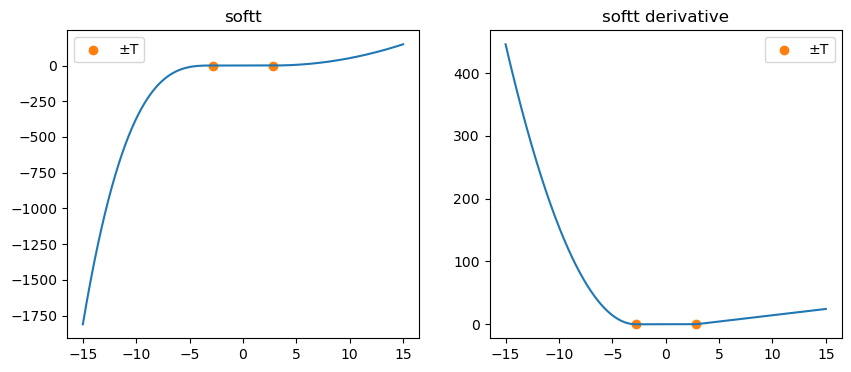

In [4]:
def softt_derivative(y, T): 
    # TODO: your code here
    return torch.autograd.grad(outputs=softt(y,T), inputs=y, allow_unused=True)[0]

# Test your code
a = torch.tensor(1.20, requires_grad=True)
print(softt_derivative(a, 3.14))

# Plot
# TODO: your code here
ys = torch.linspace(-15,15,1000, requires_grad=True)
T = 2.81

function_values = []
derivatives = []
for y in ys:
    function_values.append(softt(y,T).item())
    der = softt_derivative(y,T)
    if der is None:
        der = 0.0
    derivatives.append(der)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(ys.detach().numpy(), function_values)
ax[0].scatter(x = [-T, T], y=[0, 0], c='tab:orange', label='±T')
ax[0].legend()
ax[0].set_title("softt")
ax[1].plot(ys.detach().numpy(), derivatives)
ax[1].scatter(x = [-T, T], y=[0, 0],c='tab:orange', label='±T')
ax[1].legend()
ax[1].set_title("softt derivative")



**C)** We will now code a differentiable module using `torch.nn.Module`. 

First, let us extend the definition of 
the soft-thresholding $f_T$ to vectors by applying the soft-thresholding operation component-wise. 

Now write a differentiable module which implements the transformation $g_{T}(\cdot; M): \mathbb{R}^d \to \mathbb{R}^d$ 
given by 
$$
    g_{T}(x; M) = M^{-1} \, f_T(Mx) \,,
$$
where $M \in \mathbb{R}^{d \times d}$, a symmetric matrix, is a *parameter* of the module. (Recall: parameters maintain state of the module; register a parameter in `torch.nn.Module` by using the `torch.nn.Parameter` wrapper).

Supply $T > 0$ and and initial value $M_0 \in \mathbb{R}^{d \times d}$ symmetric to the constructor, while the `forward` method only accepts $x \in \mathbb{R}^d$ as an input. 

You may use the function `create_symmetric_invertible_matrix` to create this matrix `M`.

In [5]:
import numpy as np
def create_symmetric_invertible_matrix(dimension):
    # return symmetric invertible square matrix of size `dimension` x `dimension`
    rng = np.random.RandomState(dimension)
    factor = rng.randn(dimension, dimension).astype(np.float32)
    return 1e-6 * torch.eye(dimension) + torch.from_numpy(np.matmul(factor, factor.T))
    
class MatmulSofttMatmulinv(torch.nn.Module):
    #### TODO: your code here
    def __init__(self, T, M):
        super(MatmulSofttMatmulinv, self).__init__()
        self.T = T
        self.M = torch.nn.Parameter(M, requires_grad=True)
        self.M_1 = torch.inverse(self.M)

    def forward(self,x):
        Mx = torch.matmul(self.M,x)
        ft = torch.zeros_like(Mx)
        for i,x_ in enumerate(Mx):
            ft[i] = softt(x_, self.T)
        
        return torch.matmul(self.M_1,ft)

**D)** Initialize the module with $T = 2.81$ and $M_0$ using the function `create_symmetric_invertible_matrix`. 
Use `dimension=5`. Pass in the following vector `x` defined below and compute $g_T(x;M_0)$.

In [6]:
import numpy as np
dimension = 5
T = 2.81
x = torch.randn(5, requires_grad=True)
print('x:', x)
# TODO: your code here
M_0 = create_symmetric_invertible_matrix(dimension=5)
module = MatmulSofttMatmulinv(T, M_0)
gt = module(x)
print(gt)

x: tensor([ 1.0082, -0.1845, -0.9920,  0.7688, -0.6800], requires_grad=True)
tensor([  3.8702,  17.0693, -10.9759,  18.2213,   6.0320],
       grad_fn=<MvBackward0>)


**E)** For the same vector `x` as defined above, compute and print out the gradient of $\varphi_T(x; M) = \|x - g_T(x; M)\|_2^2$
with respect to both $x$ and $M$ using automatic differentiation. Use $T=2.81$ again.

In [7]:
# TODO: your code here

phi = torch.norm(x - gt)**2
gradient = torch.autograd.grad(outputs=phi, inputs=[x,module.M], allow_unused=True)
gradient

(tensor([ -587.1085, -5833.9985,  6687.7197,  3943.9590,   148.6247]),
 tensor([[ -284.6529,   364.1271,   154.2504,    50.9885,   343.6937],
         [ -264.1067, -1165.8801,   749.4370, -1244.3525,  -412.1448],
         [ 1717.1155,  -775.5817, -1503.4299,   912.9783, -1382.4791],
         [  966.6891, -1137.9874,  -563.5945,   -88.4649, -1119.2599],
         [  112.4168,  -333.9762,    15.7627,  -183.4904,  -228.1855]]))

# Part 3: Optimizing a multi-layer perceptron
In this exercise, you will find the divergent learning rate of a MLP and implement a variant of SGD with parameter averaging. 

We will start with the dataloading utilities. 

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


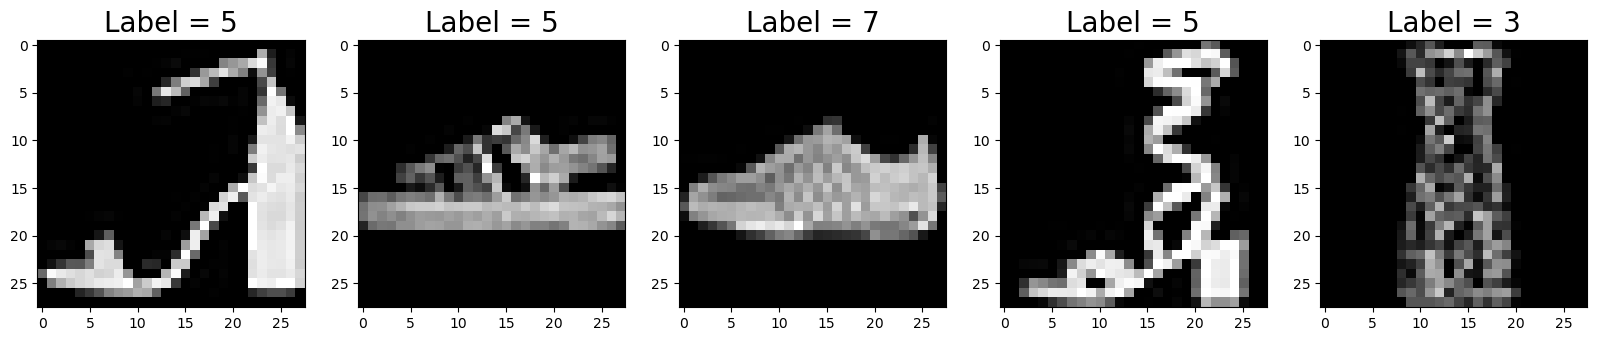

In [8]:
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy

# download dataset (~117M in size)
train_dataset = FashionMNIST('../data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('../data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    


# Normalize dataset: pixel values lie between 0 and 255
# Make them zero mean

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) 

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :])

n_class = np.unique(y_train).shape[0]

**A)** Code up a MLP with three hidden layers with 32, 16, and 12 hidden units respectively. We will use a batch size of 8 throughout. The objective function we will use is the multinomial logistic loss, also known in PyTorch as `cross_entropy`. 

You **may reuse** code from previous labs and demos for this part.

In [9]:
from torch.nn.functional import cross_entropy, relu

def compute_objective(mlp, X, y):
    """ Compute the multinomial logistic loss. 
        mlp is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = mlp(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(mlp, X, y):
    """ Compute the  accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(mlp, verbose=False):
    train_loss = compute_objective(mlp, X_train, y_train)
    test_loss = compute_objective(mlp, X_test, y_test)
    train_accuracy = compute_accuracy(mlp, X_train, y_train)
    test_accuracy = compute_accuracy(mlp, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def minibatch_sgd_one_pass(mlp, X, y, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        # compute the objective. 
        objective = compute_objective(mlp, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=mlp.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(mlp.parameters(), gradients):
                w -= learning_rate * g
    
    return mlp

In [10]:
# TODO: your code here
from typing import List

class MyMLP(torch.nn.Module):
    def __init__(self, input_dim:int, nclasses:int, hidden_sizes: List[int]):
        super(MyMLP, self).__init__()
        self.nclasses = nclasses
        
        assert len(hidden_sizes) == 3, "Only 3 hidden sizes must be given"
        
        self.linear1 = torch.nn.Linear(input_dim, hidden_sizes[0])
        self.linear2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.linear3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.linear4 = torch.nn.Linear(hidden_sizes[2], nclasses)

    def forward(self,x):

        out = self.linear1(x)
        relu(out)
        out = self.linear2(out)
        relu(out)
        out = self.linear3(out)
        relu(out)
        out = self.linear4(out)

        return out

**B)** Find the divergent learning rate.

**Note**: We changed the data pre-processing (our data no longer has unit variance), which could cause the divergent learning rate to be different from what we had in previous labs.

In [11]:
# TODO: your code here
batch_size = 8
lr = 2e-3
hidden_sizes = [32,16,12]

model = MyMLP(input_dim=X_train[0].shape[0], 
              nclasses=y_train.unique().shape[0],
              hidden_sizes=hidden_sizes)

_ = compute_logs(model, verbose=True)
_ = minibatch_sgd_one_pass(model, X_train, y_train, lr, batch_size, verbose=True)
_ = compute_logs(model, verbose=True)

Train Loss = 13.894, Train Accuracy = 0.071, Test Loss = 14.063, Test Accuracy = 0.072
2.459844730797025
1.4469931284355655
0.9753113933226071
0.7735854957165592
0.6985087836877842
0.6444930333306529
0.6277248548867124
Train Loss = 0.644, Train Accuracy = 0.774, Test Loss = 0.719, Test Accuracy = 0.750


2e-3 is a good candidate for the divergent learning rate because at 4e-3 loss diverges to nan. We show this below:

In [12]:

batch_size = 8
lr = 4e-3
hidden_sizes = [32,16,12]

model = MyMLP(input_dim=X_train[0].shape[0], 
              nclasses=y_train.unique().shape[0],
              hidden_sizes=hidden_sizes)

_ = compute_logs(model, verbose=True)
_ = minibatch_sgd_one_pass(model, X_train, y_train, lr, batch_size, verbose=True)
_ = compute_logs(model, verbose=True)

Train Loss = 10.804, Train Accuracy = 0.134, Test Loss = 10.801, Test Accuracy = 0.129
2.0083077313643756
1.2959986967082402
0.9668591974255811
0.7524455820095212
0.7150950363212537
0.6311547907278999
0.626874805068622
Train Loss = 0.547, Train Accuracy = 0.821, Test Loss = 0.614, Test Accuracy = 0.796


**We will use 1e-3 as the learning rate to train the model.**

**C)** We will implement averaged SGD with an exponentially moving average. 
In addition to the model parameters $w_t$, we 
also maintain a separate set of parameters $\bar w_t$ to serve as an average. The updates of averaged SGD are
$$
    w_{t+1} = w_t - \eta g_t \\
    \bar w_{t+1} = (1 - \gamma) \bar w_t + \gamma w_{t+1},
$$
where $\eta$ is a learning rate, $g_t$ is a (minibatch) stochastic gradient at $w_t$ and $\gamma \in (0, 1)$ is an average weight. 

Some notes:
- the update of $w_t$ is identical to the regular SGD method. That is, the averaged parameter $\bar w_t$ is *not* used during the stochastic gradient updates. 
- The averaged parameter $\bar w_t$ is updated on the side and never to be used in model updates. We use $\bar w_t$ for logging only. 

Your task is to train the model for $25$ epochs and plot the train/test loss/accuracy for both the unaveraged model $w_t$ as well as the averaged_model $\bar w_t$ in the same plot. Use a batch size of $8$ and half the divergent learning rate you found in the previous part. We will use the average weight as $\gamma = 10^{-3}$.


**NOTE**: Do not include the logs of the first two passes through the data in the plot. This is because the inital loss is always very large and this tends to drown out the more interesting patterns we observe later on during training. 
 
    

In [13]:
def minibatch_sgd_one_pass_exp(mlp, mlp2, X, y, learning_rate, batch_size, gamma, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        # compute the objective. 
        objective = compute_objective(mlp, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=mlp.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(mlp.parameters(), gradients):
                w -= learning_rate * g
        
        # update the second set of parameters
        with torch.no_grad():
            for (w, w2) in zip(mlp.parameters(), mlp2.parameters()):
                w2 *= (1 - gamma)
                w2 += gamma * w
    
    return mlp, mlp2

In [14]:
# TODO: your code here
import copy
lr = 1e-3
batch_size = 8
epochs = 25
gamma = 1e-3
hidden_sizes = [32,16,12]

model = MyMLP(input_dim=X_train[0].shape[0], 
              nclasses=y_train.unique().shape[0],
              hidden_sizes=hidden_sizes)

model2 = copy.deepcopy(model)

logs = []
logs_exp = []
for _ in range(epochs):
    logs.append(compute_logs(model, verbose=True))
    model, model2 = minibatch_sgd_one_pass_exp(model, model2, X_train, y_train, lr, batch_size, gamma)
    logs_exp.append(compute_logs(model2, verbose=False))


Train Loss = 12.325, Train Accuracy = 0.082, Test Loss = 12.320, Test Accuracy = 0.078
Train Loss = 0.560, Train Accuracy = 0.803, Test Loss = 0.650, Test Accuracy = 0.779
Train Loss = 0.516, Train Accuracy = 0.824, Test Loss = 0.632, Test Accuracy = 0.784
Train Loss = 0.480, Train Accuracy = 0.836, Test Loss = 0.611, Test Accuracy = 0.793
Train Loss = 0.422, Train Accuracy = 0.861, Test Loss = 0.586, Test Accuracy = 0.807
Train Loss = 0.442, Train Accuracy = 0.853, Test Loss = 0.611, Test Accuracy = 0.803
Train Loss = 0.385, Train Accuracy = 0.867, Test Loss = 0.593, Test Accuracy = 0.811
Train Loss = 0.400, Train Accuracy = 0.858, Test Loss = 0.619, Test Accuracy = 0.797
Train Loss = 0.381, Train Accuracy = 0.863, Test Loss = 0.616, Test Accuracy = 0.803
Train Loss = 0.380, Train Accuracy = 0.870, Test Loss = 0.640, Test Accuracy = 0.796
Train Loss = 0.357, Train Accuracy = 0.878, Test Loss = 0.646, Test Accuracy = 0.803
Train Loss = 0.327, Train Accuracy = 0.889, Test Loss = 0.626, 

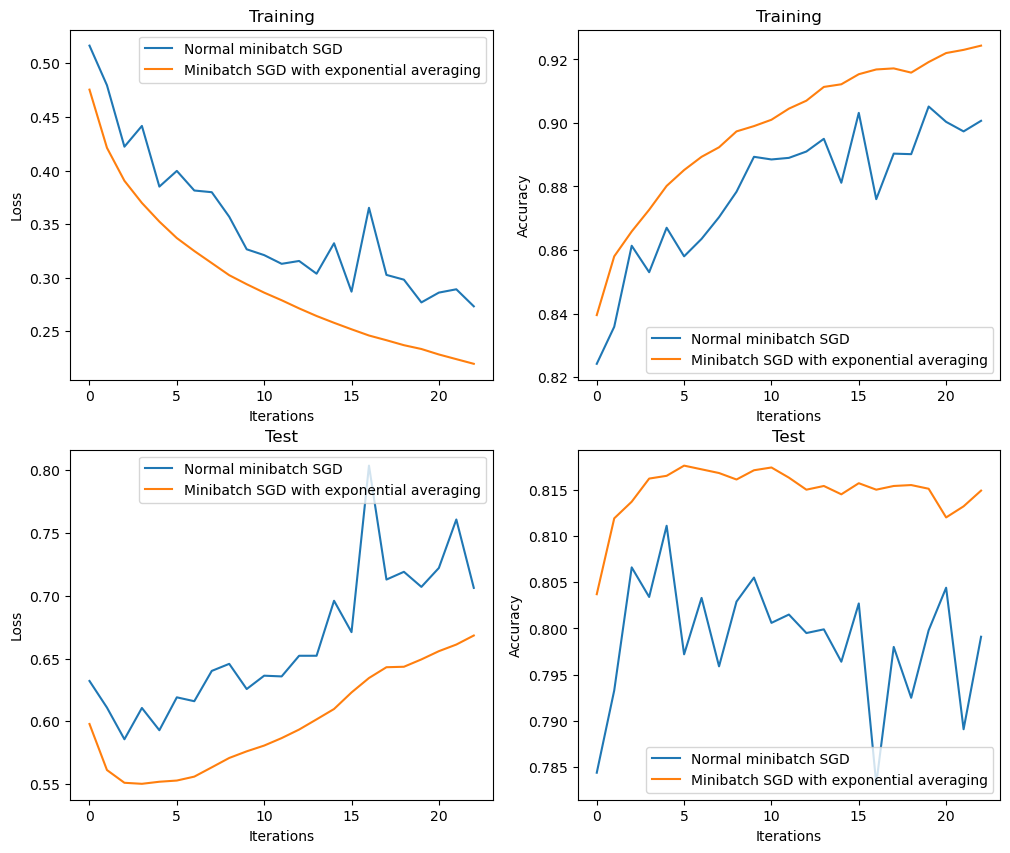

In [15]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,10)
for a in ax.flatten(): a.set_xlabel("Iterations")
for a in ax: a[0].set_ylabel("Loss")
for a in ax: a[1].set_ylabel("Accuracy")
for a in ax[0,:]: a.set_title("Training")
for a in ax[1,:]: a.set_title("Test")

names = zip([logs, logs_exp], ["Normal minibatch SGD", "Minibatch SGD with exponential averaging"])
for log, label in names:
    log = np.asarray(log)
    ax[0,0].plot(log[2:,0], label = label)
    ax[0,0].legend()
    ax[0,1].plot(log[2:,1], label = label)
    ax[0,1].legend()
    ax[1,0].plot(log[2:,2], label = label)
    ax[1,0].legend()
    ax[1,1].plot(log[2:,3], label = label)
    ax[1,1].legend()

For the same number of epochs, loss seems to be lower, and accuracy seems to be higher for minibatch SGD with exponential averaging. The curves are also much smoother.

## Part 4: CNN Short Answer
Choose **1 from each section** of the following problems to complete.

**Section 1 (choose 1)**

a. Given a image of size =20 , what is the output shape if it is put through a convolutional neural net with kernel size=3, padding = 2, stride = 4, and number of out_channels = 16? Justify your answer based on the ideas of kernel size, padding, and stride. 

b. For a stride=2, what kind of dependencies in text would you expect the model be able to capture?

c. Do we need a separate minimum pooling layer? Can you replace it with another operation?

**Section 2 (choose 1)**

c. What are the computational and statistical benefits of a stride larger than 1?

d. What is the computational cost of the pooling layer? Assume that the input to the pooling layer is of size $c\times h\times w$,the pooling window has a shape of $p_h \times p_w$ with a padding of $(p_h, p_w)$ and a stride of $(s_h, s_w)$.

**Answers:**

*Section 1. a.*

We are given,
$$
W = 20, \ K = 3,\ P = 2,\ S = 4,\ N = 16
$$

The output size of one convolution filter is,
$$
W_{new} = \frac{W-K+2P}{S}+1 = \frac{20-3+2*2}{4}+1 = 5.2 + 1 \approx 6
$$

Since we have $N=16$ filters, the dimensions of the flattened output $= 16*6*6 = 576$ pixels

*Section 2. c.*

The computational benefits of a stride > 1 are that we reduce the number of steps taken by the kernel over an image by a factor of the stride length. For example, a stride length $S=2$ reduces the steps taken over an image by half (since we take 2 steps after each multiplication with the filter). If the horizontal and vertical strides are both > 1 then the number of operations performed is reduced by a factor of the product of both the stride lengths.

The statistical benefits of a stride larger than 1 is that it acts like a downsampling operation. Which means that We reduce the dimensions of the output and represent the input using fewer number of pixels. This is beneficial because we are sort of compressing our input and retaining maximum information about it. We can then use this redcued representation for other downstream tasks such as classification.